Total de músicas (raw): 146612
Exemplo de letra (raw): Carolina é uma menina bem difícil de esquecer Andar bonito e um brilho no olhar Tem um jeito adolescente que me faz enlouquecer E um molejo que eu não vou te enganar Maravilha feminina, meu docinho de
Amostra usada: 10000 músicas


Limpando textos: 100%|██████████| 10000/10000 [03:32<00:00, 46.96it/s]


Após limpeza, amostra: 9995 músicas
Gêneros válidos (>= 5 músicas): 51
Gêneros pulados (poucas músicas):
genre
new age          3
ska              3
tecnopop         3
gotico           2
disco            2
chillout         2
jazz             2
classic rock     2
metal            1
reggaeton        1
electro swing    1
grunge           1
progressivo      1
industrial       1
arrocha          1
Name: count, dtype: int64
Amostra após filtrar gêneros pequenos: 9969 músicas

Extraindo tópicos por gênero...
Processado gênero axe (316 músicas) com 5 tópicos e 1292 features
Processado gênero black music (44 músicas) com 5 tópicos e 3513 features
Processado gênero blues (7 músicas) com 5 tópicos e 328 features
Processado gênero bossa nova (416 músicas) com 5 tópicos e 1498 features
Processado gênero classico (18 músicas) com 5 tópicos e 764 features
Processado gênero coletanea (20 músicas) com 5 tópicos e 735 features
Processado gênero country (58 músicas) com 5 tópicos e 337 features
Processad

Device set to use cpu
Sentimento: 100%|██████████| 9969/9969 [39:05<00:00,  4.25it/s]  


sentiment
NEUTRAL    9969
Name: count, dtype: int64


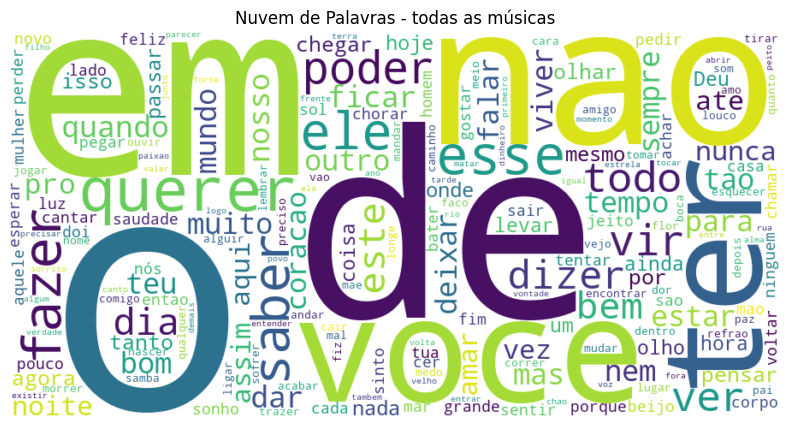

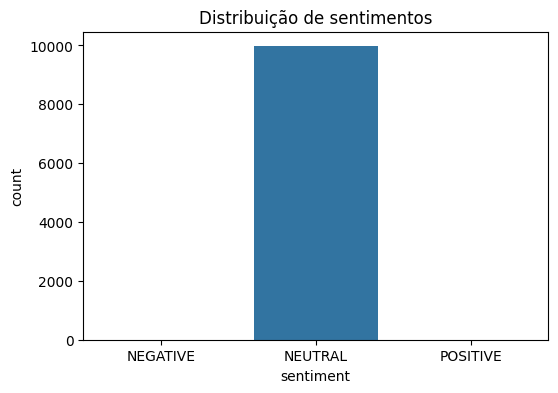


--- axe (316 músicas) ---


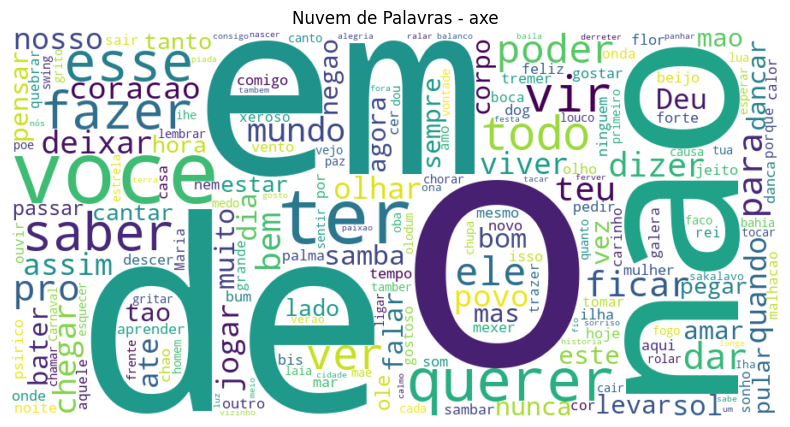


--- black music (44 músicas) ---


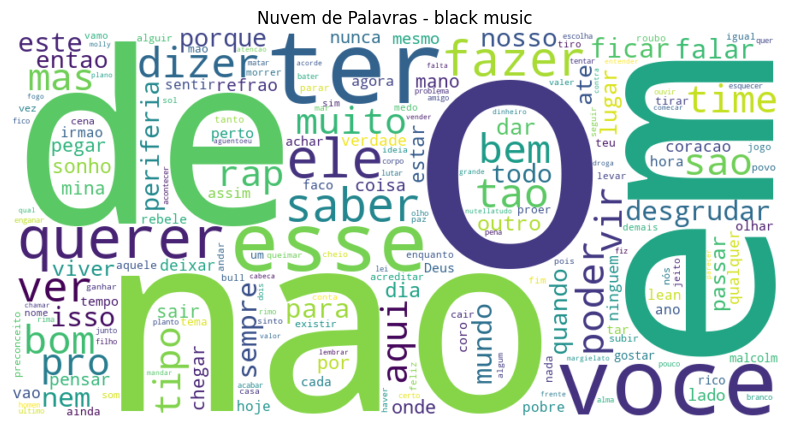


--- blues (7 músicas) ---


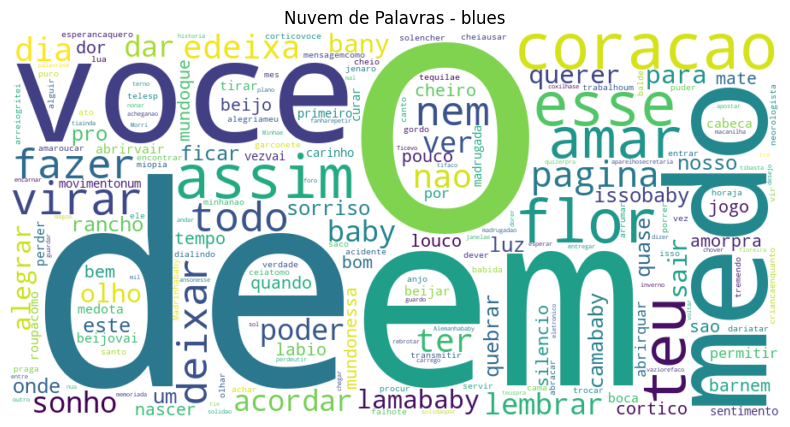


--- bossa nova (416 músicas) ---


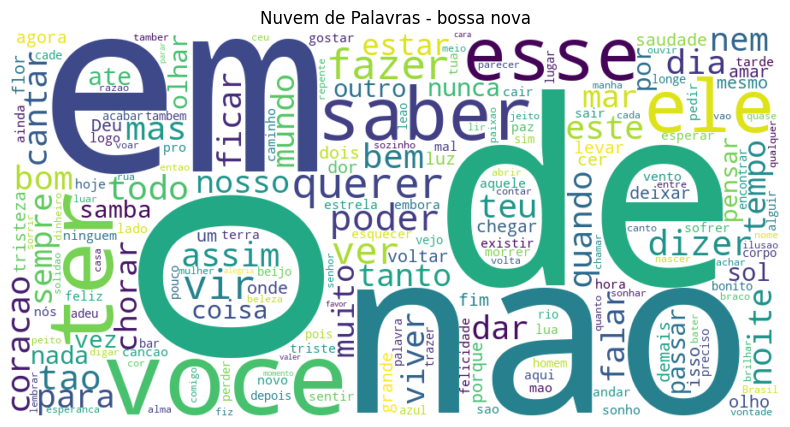


--- classico (18 músicas) ---


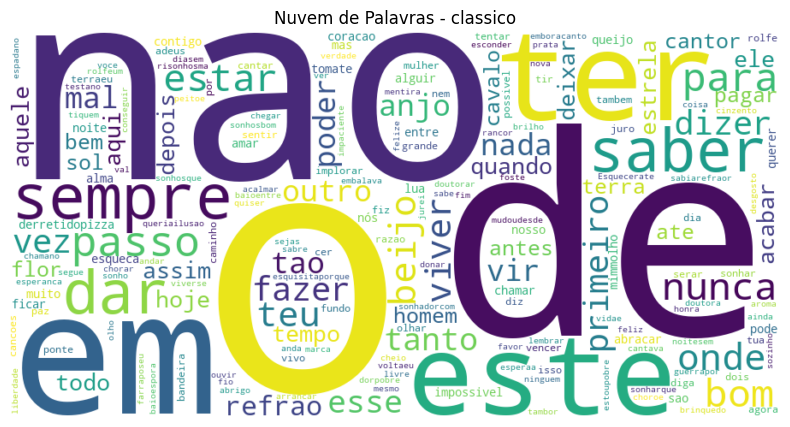


--- coletanea (20 músicas) ---


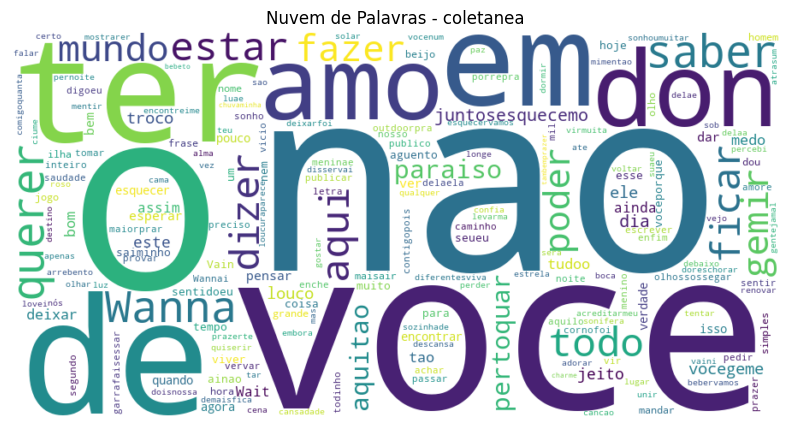


Projeto concluído! Resultados salvos em data/lyrics_with_topics_by_genre.csv


In [4]:
# 0. Configuração do notebook ---
%matplotlib inline

# 1. Importação de bibliotecas ---
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import pipeline
from spacy.cli import download
from tqdm import tqdm
import unidecode
import csv
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# 1a. spaCy (PT)
try:
    nlp = spacy.load("pt_core_news_sm")
except OSError:
    print("Baixando pt_core_news_sm ...")
    download("pt_core_news_sm")
    nlp = spacy.load("pt_core_news_sm")

# 2. dataset (modo robusto para campos com vírgulas/quebras)
INPUT_CSV = "data/brazilian_lyrics.csv"  # ajuste se necessário

with open(INPUT_CSV, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

reader = csv.DictReader(lines, quotechar='"')
data = list(reader)
df = pd.DataFrame(data)

# Suporta colunas: "Nome da Música","Artista","Gênero Musical","Letra da Música"
col_map = {}
for c in df.columns:
    lower = c.lower().strip()
    if "nome" in lower and "mús" in lower:
        col_map[c] = "title"
    elif "artista" in lower:
        col_map[c] = "artist"
    elif "gênero" in lower or "genero" in lower:
        col_map[c] = "genre"
    elif "letra" in lower or "lyrics" in lower:
        col_map[c] = "lyrics"

df = df.rename(columns=col_map)
required = ["title", "artist", "genre", "lyrics"]
for r in required:
    if r not in df.columns:
        raise RuntimeError(f"Coluna necessária faltando no CSV: {r}")

print(f"Total de músicas (raw): {len(df)}")
print("Exemplo de letra (raw):", str(df['lyrics'].iloc[0])[:200])

# 3. Normalização: minúsculas, remover acentos, substituir '-' por ' ', separar por ';' ou ','.
def normalize_genre(g):
    if pd.isna(g):
        return ""
    g = str(g).lower().strip()
    g = g.replace("-", " ")
    g = unidecode.unidecode(g)
    return g

df["genre"] = df["genre"].apply(normalize_genre)

# Delimitadores comuns ( ; or , )
df["genre"] = df["genre"].str.replace("/", ";")  # padroniza / para ;
df["genre"] = df["genre"].str.replace("|", ";")
df["genre"] = df["genre"].str.split(";|,")  # cria listas
df = df.explode("genre")
df["genre"] = df["genre"].fillna("").str.strip()

# Entradas vazias de gênero
df = df[df["genre"] != ""]

# 4. Amostra para processamento rápido
SAMPLE_SIZE = min(10000, len(df))  # ajustar dps
df_sample = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
print(f"Amostra usada: {len(df_sample)} músicas")

# 5. Pré-processamento / limpeza das letras
tqdm.pandas(desc="Limpando textos")
def generate_auto_stopwords(texts, top_n_freq=50, idf_thresh=1.5):
    """
    texts: lista de textos limpos
    top_n_freq: remove as N palavras mais frequentes
    idf_thresh: remove palavras com idf < idf_thresh (muito comuns)
    """
    # --- frequência simples ---
    all_tokens = " ".join(texts).split()
    token_counts = Counter(all_tokens)
    freq_stopwords = [w for w, _ in token_counts.most_common(top_n_freq)]

    # --- TF-IDF ---
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    idf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
    idf_stopwords = [w for w, v in idf.items() if v < idf_thresh]

    # combinar e remover duplicados
    auto_stopwords = set(freq_stopwords + idf_stopwords)
    return auto_stopwords

# gerar stopwords automáticas
auto_stopwords = generate_auto_stopwords(df_sample["lyrics"], top_n_freq=50, idf_thresh=1.5)

def clean_text(text, do_lemmatize=True, remove_stopwords=True, stopwords_set=None):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^A-Za-zÀ-ÖØ-öø-ÿ\s]", " ", text)
    text = text.lower().strip()
    text = unidecode.unidecode(text)

    doc = nlp(text)
    tokens = []
    for t in doc:
        if t.is_space or t.is_punct:
            continue
        lemma = t.lemma_.strip()
        if remove_stopwords and stopwords_set and lemma in stopwords_set:
            continue
        if len(lemma) < 3:
            continue
        tokens.append(lemma)
    return " ".join(tokens)

# remove_stopwords=False como fizemos ajusta dps
df_sample["clean_text"] = df_sample["lyrics"].progress_apply(
    lambda t: clean_text(t, do_lemmatize=True, remove_stopwords=True, stopwords_set=auto_stopwords)
)
# Remove linhas com texto vazio após limpeza
df_sample = df_sample[df_sample["clean_text"].str.strip() != ""].reset_index(drop=True)
print(f"Após limpeza, amostra: {len(df_sample)} músicas")

# 6. Filtrar gêneros com pelo menos N músicas (para rodar LDA com estatística)
MIN_PER_GENRE = 5
genre_counts = df_sample["genre"].value_counts()
valid_genres = genre_counts[genre_counts >= MIN_PER_GENRE].index.tolist()
print(f"Gêneros válidos (>= {MIN_PER_GENRE} músicas): {len(valid_genres)}")

# lista de gêneros pulados
skipped = genre_counts[genre_counts < MIN_PER_GENRE]
if not skipped.empty:
    print("Gêneros pulados (poucas músicas):")
    print(skipped.head(20))

df_sample = df_sample[df_sample["genre"].isin(valid_genres)].reset_index(drop=True)
print(f"Amostra após filtrar gêneros pequenos: {len(df_sample)} músicas")

# 7. Modelagem de tópicos (LDA) por gênero
lda_results = []
stopwords_pt = spacy.lang.pt.stop_words.STOP_WORDS  # usa dps

print("\nExtraindo tópicos por gênero...")
for genre, df_gen in df_sample.groupby("genre"):
    df_gen = df_gen.copy()
    df_gen = df_gen[df_gen["clean_text"].str.strip() != ""]
    n_docs = len(df_gen)
    if n_docs < MIN_PER_GENRE:
        print(f"Gênero {genre} pulado (menos de {MIN_PER_GENRE})")
        continue

    # Vectorizer: sem remover stopwords por exigência; ajustar min_df conforme n_docs
    min_df = 2 if n_docs >= 50 else 1
    vectorizer = CountVectorizer(max_df=0.95, min_df=min_df, stop_words=None)
    try:
        X = vectorizer.fit_transform(df_gen["clean_text"])
    except Exception as e:
        print(f"Gênero {genre} pulado: erro no vectorizer -> {e}")
        continue

    n_features = X.shape[1]
    if n_features == 0:
        print(f"Gênero {genre} pulado: zero features após vectorizer")
        continue

    # Ajustar número de tópicos para não exceder features
    n_topics = min(5, max(1, n_features // 5))
    try:
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
    except Exception as e:
        print(f"Gênero {genre} pulado: erro no LDA -> {e}")
        continue

    # atribuir tópico dominante
    topic_vals = lda.transform(X)
    df_gen = df_gen.reset_index(drop=True)
    df_gen["topic"] = topic_vals.argmax(axis=1)

    # opcional: salvar top words para inspeção
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_topic = []
    for t_idx, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_idx]
        top_words_per_topic.append(top_words)
    df_gen.attrs["top_words"] = top_words_per_topic

    lda_results.append(df_gen)
    print(f"Processado gênero {genre} ({n_docs} músicas) com {n_topics} tópicos e {n_features} features")

# concatena resultados (garante existência)
if lda_results:
    df_sample_topics = pd.concat(lda_results, ignore_index=True)
    print(f"\nTotal de músicas com tópicos: {len(df_sample_topics)}")
else:
    df_sample_topics = pd.DataFrame(columns=df_sample.columns.tolist() + ["topic"])
    print("\nNenhum gênero processado (lda_results vazio).")

# 8. Análise de sentimentos (opcional, robusta a textos longos)
compute_sentiment = True  # coloque False para pular (útil se sem internet)

if compute_sentiment and not df_sample_topics.empty:
    print("\nAnalisando sentimentos (blocos para evitar erro de tamanho)...")

    try:
        sentiment_pipeline = pipeline("sentiment-analysis", model="pysentimiento/robertuito-sentiment-analysis")
    except Exception as e:
        print("Não foi possível carregar modelo de sentimento:", e)
        sentiment_pipeline = None

    def sentiment_for_long_text(text, pipeline_obj, chunk_chars=400):
        if pipeline_obj is None:
            return np.nan
        if not isinstance(text, str) or text.strip() == "":
            return np.nan
        # quebrar por caracteres (aprox evita overflow de tokens)
        chunks = [text[i:i + chunk_chars] for i in range(0, len(text), chunk_chars)]
        try:
            results = pipeline_obj(chunks)
        except Exception:
            # fallback: processar chunk por chunk
            results = []
            for c in chunks:
                try:
                    results.extend(pipeline_obj([c]))
                except Exception:
                    results.append({"label": "NEUTRAL", "score": 0.0})
        # map labels para score numérico
        label_map = {"POSITIVE": 1, "NEGATIVE": -1, "NEUTRAL": 0,
                     "Positive":1, "Negative":-1, "Neutral":0,
                     "positive":1,"negative":-1,"neutral":0}
        nums = []
        for r in results:
            lab = r.get("label", "")
            nums.append(label_map.get(lab, 0))
        # média e conversão final
        m = np.mean(nums) if len(nums)>0 else 0
        if m > 0.2:
            return "POSITIVE"
        elif m < -0.2:
            return "NEGATIVE"
        else:
            return "NEUTRAL"

    if sentiment_pipeline is not None:
        # computa sentimento para todo df (demora mtooo)
        tqdm.pandas(desc="Sentimento")
        df_sample_topics["sentiment"] = df_sample_topics["clean_text"].progress_apply(
            lambda t: sentiment_for_long_text(t, sentiment_pipeline, chunk_chars=400)
        )
        print(df_sample_topics["sentiment"].value_counts(dropna=False))
    else:
        print("Pipeline de sentimento indisponível — pulando passo de sentimento.")
        df_sample_topics["sentiment"] = np.nan

else:
    print("Análise de sentimento desabilitada pelo usuário (compute_sentiment=False).")
    df_sample_topics["sentiment"] = np.nan

# 9. Visualizações 
def plot_wordcloud(texts, title="Nuvem de palavras"):
    text = " ".join(texts)
    if len(text.strip())==0:
        print(f"Nuvem vazia para {title}")
        return
    wc = WordCloud(width=900, height=450, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    plt.close()

if not df_sample_topics.empty:
    # geral
    plot_wordcloud(df_sample_topics["clean_text"], title="Nuvem de Palavras - todas as músicas")
    # sentimento
    if df_sample_topics["sentiment"].notna().sum() > 0:
        plt.figure(figsize=(6,4))
        sns.countplot(x="sentiment", data=df_sample_topics, order=["NEGATIVE","NEUTRAL","POSITIVE"])
        plt.title("Distribuição de sentimentos")
        plt.show()
        plt.close()

    # por genero: mostrar alguns géneros
    for genre in df_sample_topics["genre"].unique()[:6]:
        sub = df_sample_topics[df_sample_topics["genre"] == genre]
        print(f"\n--- {genre} ({len(sub)} músicas) ---")
        plot_wordcloud(sub["clean_text"], title=f"Nuvem de Palavras - {genre}")
        # mostra top words do LDA se existirem
        if hasattr(sub, "attrs") and "top_words" in sub.attrs:
            print("Top words (por tópico):", sub.attrs["top_words"])
        else:
            # top words a partir do primeiro group lda_results (se guardou)
            pass

# 10. Resultados
OUTPATH = "data/lyrics_with_topics_by_genre.csv"
df_sample_topics.to_csv(OUTPATH, index=False)
print(f"\nProjeto concluído! Resultados salvos em {OUTPATH}")
